## Setup (first 3 blocks for google colab)

In [1]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load libraries
import torch
import torch.nn as nn
from torch.nn import functional as F

import torchvision.transforms as T
from torchvision import models

import io
import requests
import numpy as np
import PIL
from PIL import Image
import cv2

from collections import namedtuple
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 0
%matplotlib inline

## Load data and model

In [0]:
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'
dtype = torch.cuda.FloatTensor

def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = '/content/drive/My Drive/DL_projects/cv_net_visualization/imagenet_val_25.npz'
    f = np.load(imagenet_fn, allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

def load_model(model_id):
    if model_id == 1:
        net = models.squeezenet1_1(pretrained=True)
    elif model_id == 2:
        net = models.resnet50(pretrained=True)
    elif model_id == 3:
        net = models.densenet161(pretrained=True)
    return net

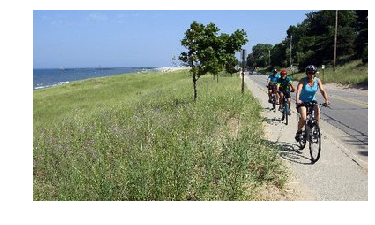

In [5]:
# fetch the image from the url
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))   # (216, 380)

plt.axis('off')
plt.imshow(img_pil)

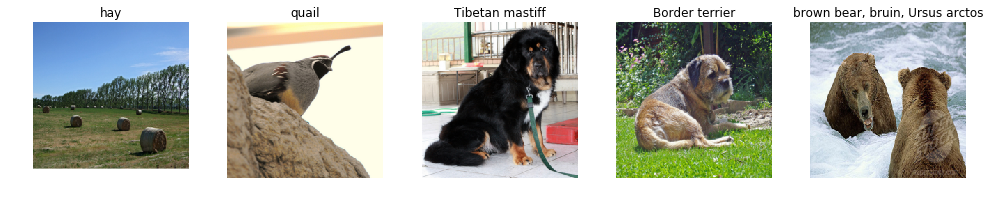

In [12]:
imgs_array, labels, cls_names = load_imagenet_val(num=5)

plt.figure(figsize=(14, 8))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(imgs_array[i])
    plt.title(cls_names[labels[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Obtain output prediction and compute the grad-CAM

In [0]:
# ndarray to pil image
def array_to_pil(img):
    return Image.fromarray(np.uint8(img)*255)

# preprocess input images
def preprocess(img):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

# compute gradients
def compute_backprop(X, y, model):
    """input: tensors X, y; pytorch model"""
    model.eval()
    scores = model(X)
    correct_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    loss = correct_scores.sum()
    loss.backward()

# forward propagation for inference
def get_preds(img, model):
    """input img tensor, pytorch model"""
    model.eval()
    logit = model(img)   # (1, 1000)
    h_x = F.softmax(logit, dim=1).data.squeeze()   # (1000,) probability of each class for this image
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()
    return probs, idx

# feature extractor
def extract_features(x, model):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - model: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    model.eval()
    features = []
    prev_feat = x
    for i, module in enumerate(model._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    return features

In [92]:
net = load_model(model_id=1)
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
features_blobs = extract_features(img_tensor, net.features)   # list of features output from each layer
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Final output tensor shape (before classifer): (1, 512, 13, 13)


In [93]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}   # same as cls_names

# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([671, 444, 880, 603, 975])

In [94]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.678 -> mountain bike, all-terrain bike, off-roader
0.088 -> bicycle-built-for-two, tandem bicycle, tandem
0.042 -> unicycle, monocycle
0.038 -> horse cart, horse-cart
0.019 -> lakeside, lakeshore


In [0]:
class Net_classifier(nn.Module):
    def forward(self, x): return torch.flatten(net.classifier(x), 1)

class GradCAM(nn.Module):
    def __init__(self):
        super(GradCAM, self).__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, feature_maps, feature_grads):
        # features size: (1, k, h, w)
        map_weights = self.ap(feature_grads)   # (1, k, 1, 1)
        maps = torch.sum(map_weights * feature_maps, 1)   # (1, h, w)
        grad_cam = F.relu(maps.squeeze(0))
        return grad_cam

def imresize(img, size):
    im = Image.fromarray(img)
    return np.array(im.resize(size, PIL.Image.BICUBIC))

def returnCAM(feature_maps, class_idx):
    # generate the class activation maps (CAMs) upsample to 256x256
    size_upsample = (256, 256)
    net_classifier = Net_classifier()
    
    feature_maps = torch.tensor(feature_maps).type(dtype)
    feature_maps.requires_grad_()

    output_cam = []
    for idx in class_idx:
        compute_backprop(feature_maps, torch.cuda.LongTensor([idx]), net_classifier)
        gradCAM = GradCAM()
        cam = gradCAM(feature_maps, feature_maps.grad).detach().cpu().numpy()
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        output_cam.append(imresize(cam, size_upsample))
    return output_cam

In [96]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[-1], [idx[0], idx[4]])
CAMs[0].shape, CAMs[1].shape

((256, 256), (256, 256))

## Render the output grad-CAM

In [0]:
# heatmap from cv2
print('output for the top-1 prediction: %s'%classes[idx[0]])

width, height = img_pil.size
heatmap = cv2.resize(CAMs[0],(width, height))   # (216, 380)
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)   # (216, 380, 3)

output for the top-1 prediction: mountain bike, all-terrain bike, off-roader


In [0]:
## mountain bike
# heatmap and result from PIL
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))   # (216, 380)

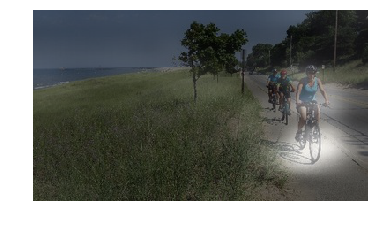

In [98]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

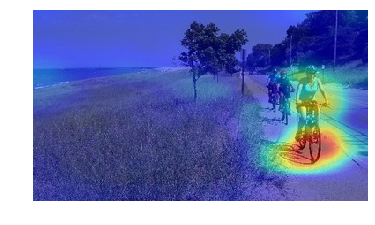

In [99]:
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

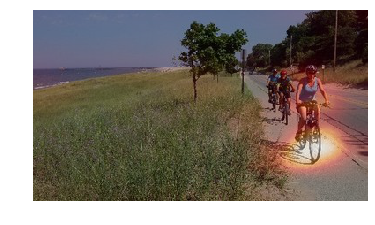

In [100]:
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='gist_heat', alpha=0.4)
#plt.colorbar()
plt.show()

In [0]:
## lakeside
# heatmap and result from PIL
heatmap = imresize(CAMs[1], (width, height))   # (216, 380)

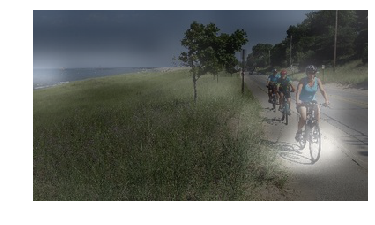

In [102]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

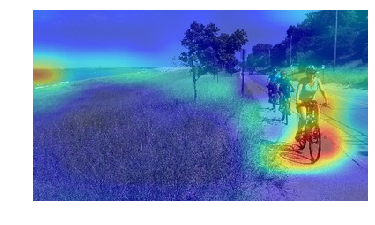

In [103]:
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

## ResNet-50 result

In [0]:
# feature extractor
def extract_features(x, model):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - model: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    model.eval()
    features = []
    prev_feat = x
    for module_name in list(net._modules.keys())[:-2]:
        next_feat = net._modules[module_name](prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    return features

In [71]:
net = load_model(model_id=2)
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
features_blobs = extract_features(img_tensor, net)
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s] 


Final output tensor shape (before classifer): (1, 2048, 7, 7)


In [106]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([671, 444, 880, 975, 978])

In [107]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.491 -> mountain bike, all-terrain bike, off-roader
0.219 -> bicycle-built-for-two, tandem bicycle, tandem
0.143 -> unicycle, monocycle
0.054 -> lakeside, lakeshore
0.034 -> seashore, coast, seacoast, sea-coast


In [0]:
# generate grad-CAM for the top1 prediction
class Net_classifier(nn.Module):
    def forward(self, x):
        x = net.avgpool(x)
        x = torch.flatten(x, 1)
        x = net.fc(x)
        return x

CAMs = returnCAM(features_blobs[-1], [idx[0], idx[3]])

In [0]:
## mountain bike
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

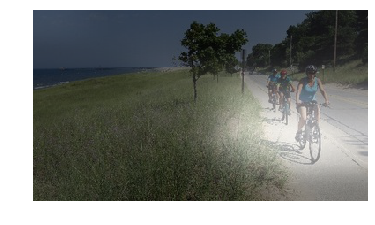

In [110]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

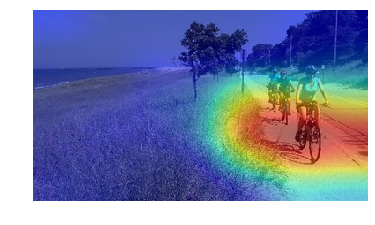

In [111]:
# ResNet-50
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

In [0]:
## lakeside
heatmap = imresize(CAMs[1], (width, height))

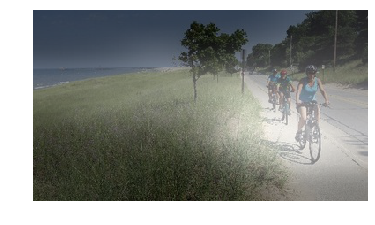

In [113]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

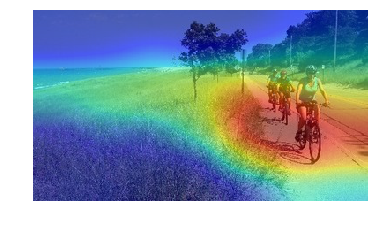

In [114]:
# ResNet-50
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

#### Other images

In [180]:
net = load_model(model_id=2)
net = net.type(dtype)
img_tensor = preprocess(array_to_pil(imgs_array[0])).type(dtype)   # (1, 3, 224, 224)
features_blobs = extract_features(img_tensor, net)   # list of features output from each layer
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Final output tensor shape (before classifer): (1, 2048, 7, 7)


In [181]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([958, 755, 649, 898, 328])

In [182]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.972 -> hay
0.003 -> radio telescope, radio reflector
0.002 -> megalith, megalithic structure
0.002 -> water bottle
0.001 -> sea urchin


In [0]:
CAMs = returnCAM(features_blobs[-1], [idx[0]])
heatmap = imresize(CAMs[0], (224, 224))

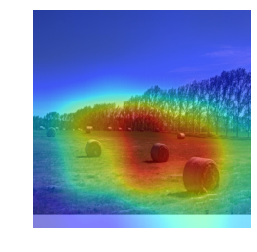

In [185]:
plt.axis('off')
plt.imshow(imgs_array[0])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

In [0]:
img_tensor = preprocess(array_to_pil(imgs_array[1])).type(dtype)   # (1, 3, 224, 224)
features_blobs = extract_features(img_tensor, net)   # list of features output from each layer

In [187]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([85, 87, 89, 81, 20])

In [188]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.221 -> quail
0.209 -> African grey, African gray, Psittacus erithacus
0.136 -> sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
0.076 -> ptarmigan
0.072 -> water ouzel, dipper


In [0]:
CAMs = returnCAM(features_blobs[-1], [idx[0]])
heatmap = imresize(CAMs[0], (224, 224))

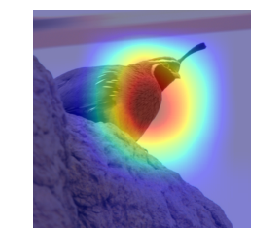

In [190]:
plt.axis('off')
plt.imshow(imgs_array[1])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

In [0]:
img_tensor = preprocess(array_to_pil(imgs_array[2])).type(dtype)   # (1, 3, 224, 224)
features_blobs = extract_features(img_tensor, net)   # list of features output from each layer

In [192]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([258, 257, 283, 270, 222])

In [193]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.633 -> Samoyed, Samoyede
0.184 -> Great Pyrenees
0.028 -> Persian cat
0.017 -> white wolf, Arctic wolf, Canis lupus tundrarum
0.015 -> kuvasz


In [0]:
CAMs = returnCAM(features_blobs[-1], [idx[0]])
heatmap = imresize(CAMs[0], (224, 224))

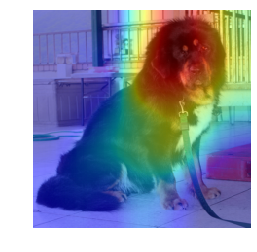

In [195]:
plt.axis('off')
plt.imshow(imgs_array[2])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

## DenseNet-161 result

In [0]:
# feature extractor
def extract_features(x, model):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - model: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    model.eval()
    features = []
    prev_feat = x
    for module in model._modules.values():
        next_feat = module(prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    next_feat = F.relu(prev_feat)
    features[-1] = next_feat.cpu().detach().numpy()
    return features

In [115]:
net = load_model(model_id=3)
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
features_blobs = extract_features(img_tensor, net.features)
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 107MB/s]


Final output tensor shape (before classifer): (1, 2208, 7, 7)


In [116]:
# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([671, 444, 880, 978, 970])

In [117]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.697 -> mountain bike, all-terrain bike, off-roader
0.180 -> bicycle-built-for-two, tandem bicycle, tandem
0.056 -> unicycle, monocycle
0.021 -> seashore, coast, seacoast, sea-coast
0.016 -> alp


In [0]:
# generate grad-CAM for the top1 prediction
class Net_classifier(nn.Module):
    def forward(self, x):
        out = F.relu(x)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = net.classifier(out)
        return out

CAMs = returnCAM(features_blobs[-1], [idx[0], idx[3]])

In [0]:
## mountain bike
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

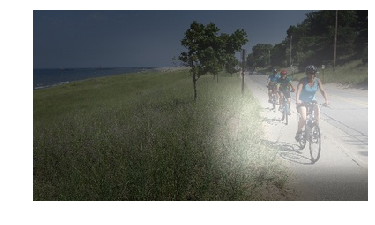

In [120]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

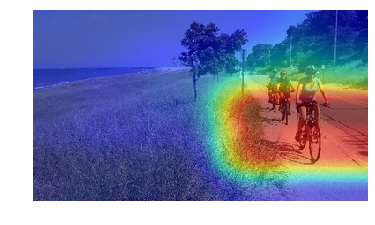

In [121]:
# DenseNet-161
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

In [0]:
## lakeside
heatmap = imresize(CAMs[1], (width, height))

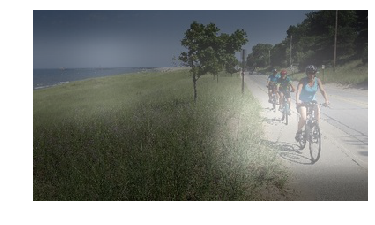

In [123]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

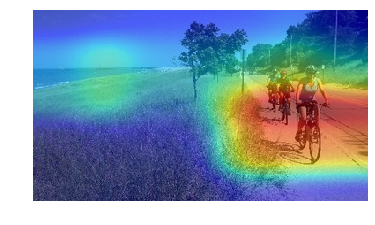

In [124]:
# DenseNet-161
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()